# Learning to Learn on a quadratic problem

### Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tqdm import tqdm
import sklearn.metrics as sm
import pandas as pd

### LSTM Parameters

In [15]:
n_dimension = 10
normal_init = tf.random_normal_initializer()
batch_size = 1
num_unroll = 20 
hidden_size = 40
num_layers = 2
epochs = 100
number_of_data = 300

### Define data

In [20]:
def get_n_samples(n_dimension, number_of_data): # Quadratic Functions as described in the paper
    theta = np.random.randn(n_dimension, 1)
    W = np.random.randn(number_of_data, n_dimension, n_dimension)
    y = np.zeros([number_of_data, n_dimension, 1])
    for i in range(number_of_data):
        y[i] = np.dot(W[i], theta)
    W = tf.convert_to_tensor(W, dtype = 'float')
    y = tf.convert_to_tensor(y, dtype = 'float')
    return W, y

In [21]:
W, y = get_n_samples(n_dimension, number_of_data)

In [22]:
train_x, test_x, valid_x, train_y, test_y, valid_y = W[:200], W[200:250], W[250:], y[:200], y[200:250], y[250:]

In [23]:
val_accuracy = sm.mean_squared_error
loss_object = tf.keras.losses.MeanSquaredError()

### Define Optimizee

In [34]:
class Optimizee(Model):
    def __init__(self):
        super(Optimizee, self).__init__()
        self.theta = tf.Variable(initial_value = normal_init(shape=(n_dimension, 1), dtype='float'), trainable=True)
        self.training_losses, self.validation_losses = [], []
        # Convert to tensor and keep the dimentsions as (n_dimensions, _)
        self.tensor_trainable_weights = tf.reshape(tf.convert_to_tensor(self.trainable_weights), (n_dimension, 1)) 
 
    def call(self, W, tensor_trainable_weights):
        return tf.matmul(W, tensor_trainable_weights) #tensor_trainable_weights is theta
    
    def loss(self, y_true, y_pred):
        error = y_true - y_pred
        return tf.reduce_mean(tf.square(error))

In [75]:
def train(W, y_train, epochs=100, for_optimizer=False):
    for epoch in range(epochs):
        loss, valid_loss, valid_accuracy = train_data_for_one_epoch(W, y_train, for_optimizer)
        model.training_losses.append(loss.numpy())
        print("Epoch: {} , training loss: {}, val loss: {}, val MSE accuracy {}".format(
            epoch, loss, valid_loss, valid_accuracy, 
        ))

def train_data_for_one_epoch(W, y, for_optimizer): 
    if for_optimizer:
      loss = apply_optimizer_gradient(W, y)
    else:       
      loss = apply_gradient(W, y)
    
    # validation dataset
    validation_predictions = model(valid_x, model.tensor_trainable_weights)
    validation_loss = loss_object(y_true=valid_y, y_pred=validation_predictions)
    validation_accuracy = val_accuracy(y_true=tf.squeeze(valid_y), y_pred=tf.squeeze(validation_predictions))
    model.validation_losses.append(validation_loss)
    
    return loss, validation_loss, validation_accuracy

def apply_optimizer_gradient(W, y):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()
    loss = 0
    
    with tf.GradientTape() as tape_master:
        tape_master.watch(LSTM_optimizer.trainable_weights)
        tape_master.watch(model.tensor_trainable_weights)
        for n in range(LSTM_optimizer.num_unroll):
            with tf.GradientTape() as tape:
                tape.watch([model.tensor_trainable_weights])
                predictions = model(W, model.tensor_trainable_weights)
                loss_value = loss_object(y_true=y, y_pred=predictions)
                loss += loss_value
                gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
            # Retrieve new results from optimizer
            lstm_optimizer_results = LSTM_optimizer(gradients) 
            # update trainable weights based on the optimer change for that step
            model.tensor_trainable_weights += lstm_optimizer_results
        
        # get final prediction for epoch        
        # calculate the gradient with respect to the average loss of all losses in the unroll?
        lstm_gradients = tape_master.gradient(loss, LSTM_optimizer.trainable_variables)
        lstm_gradients, _ = tf.clip_by_global_norm(lstm_gradients, 10.)

    optimizer_of_optimizer.apply_gradients(zip(lstm_gradients, LSTM_optimizer.trainable_weights))
    
    # calculate average loss
    loss /= LSTM_optimizer.num_unroll
    return loss

def apply_gradient(W, y):
    # Refresh state of LSTM for each batch
    LSTM_optimizer.refresh_state()    
    for n in range(LSTM_optimizer.num_unroll):
      with tf.GradientTape() as tape:
          tape.watch([model.tensor_trainable_weights])
          predictions = model(W, model.tensor_trainable_weights)
          loss_value = loss_object(y_true=y, y_pred=predictions)
          gradients = tape.gradient(loss_value, model.tensor_trainable_weights)
      # Retrieve new results from optimizer
      lstm_optimizer_results = LSTM_optimizer(gradients) 
      # update trainable weights based on the optimer change for that step
      model.tensor_trainable_weights += lstm_optimizer_results
        
    # calculate average loss
    return loss_value

### Define LSTM Optimizer

In [76]:
class LSTMOptimizer(Model):
    def __init__(self, hidden_size, num_layers, n_dimension, batch_size, num_unroll, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.dense = tf.keras.layers.Dense(1, activation='tanh')
        self.lstm_stacked_cells = tf.keras.layers.StackedRNNCells([tf.keras.layers.LSTMCell(hidden_size) for _ in range(num_layers)])
        self.state = self.lstm_stacked_cells.get_initial_state(batch_size = self.batch_size, dtype = 'float')
        self.num_unroll = num_unroll
        
    def refresh_state(self):
        self.state = self.lstm_stacked_cells.get_initial_state(batch_size = self.batch_size, dtype = 'float')

    def call(self, gradient_of_params):
        # Get parameter updates
        cell_output, state = self.lstm_stacked_cells(gradient_of_params, self.state) 
        # Transform cell output to parameter update
        parameter_updates = self.dense(cell_output)
        self.state = state 

        return parameter_updates
    

### Train optimizer

In [77]:
LSTM_optimizer = LSTMOptimizer(hidden_size=hidden_size, num_layers=num_layers, n_dimension=n_dimension, batch_size=batch_size, num_unroll=num_unroll)
optimizer_of_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [78]:
model = Optimizee()

In [79]:
train(train_x, train_y, epochs, for_optimizer=True)

Epoch: 0 , training loss: 30.150985717773438, val loss: 109.49214935302734, val MSE accuracy 109.49214935302734
Epoch: 1 , training loss: 338.26690673828125, val loss: 859.2353515625, val MSE accuracy 859.2352294921875
Epoch: 2 , training loss: 1696.222412109375, val loss: 3066.36279296875, val MSE accuracy 3066.36279296875
Epoch: 3 , training loss: 4669.0830078125, val loss: 6818.861328125, val MSE accuracy 6818.86181640625
Epoch: 4 , training loss: 9131.1884765625, val loss: 11802.0087890625, val MSE accuracy 11802.009765625
Epoch: 5 , training loss: 14749.71875, val loss: 17684.408203125, val MSE accuracy 17684.408203125
Epoch: 6 , training loss: 21226.96484375, val loss: 24210.638671875, val MSE accuracy 24210.640625
Epoch: 7 , training loss: 28340.880859375, val loss: 31218.775390625, val MSE accuracy 31218.77734375
Epoch: 8 , training loss: 35944.328125, val loss: 38597.91015625, val MSE accuracy 38597.90625
Epoch: 9 , training loss: 43929.21484375, val loss: 46254.90625, val MSE

### Train model with trained LSTM optimizer




In [80]:
model = Optimizee()


In [81]:
train(train_x, train_y, epochs, for_optimizer=False)

Epoch: 0 , training loss: 1.8633087873458862, val loss: 1.636818289756775, val MSE accuracy 1.636818289756775
Epoch: 1 , training loss: 0.854047417640686, val loss: 0.7016450762748718, val MSE accuracy 0.7016450762748718
Epoch: 2 , training loss: 0.23013836145401, val loss: 0.19027961790561676, val MSE accuracy 0.19027960300445557
Epoch: 3 , training loss: 0.17072942852973938, val loss: 0.11826010048389435, val MSE accuracy 0.11826010048389435
Epoch: 4 , training loss: 0.07039810717105865, val loss: 0.04344196990132332, val MSE accuracy 0.04344197362661362
Epoch: 5 , training loss: 0.08141107857227325, val loss: 0.046060711145401, val MSE accuracy 0.0460607148706913
Epoch: 6 , training loss: 0.060218773782253265, val loss: 0.031408462673425674, val MSE accuracy 0.03140846639871597
Epoch: 7 , training loss: 0.06702139228582382, val loss: 0.03519989550113678, val MSE accuracy 0.03519989922642708
Epoch: 8 , training loss: 0.061505790799856186, val loss: 0.03154568374156952, val MSE accura

## Hand Crafted Optimizers Train and Test

In [72]:
class NormalModel(Model):
    def __init__(self):
        super(NormalModel, self).__init__()
        self.theta = tf.Variable(initial_value = normal_init(shape=(n_dimension, 1), dtype='float'), trainable=True)
 
    def call(self, W):
        return tf.matmul(W, self.theta)

In [50]:
adam_model = NormalModel()
adam_model.compile(optimizer='adam', loss='mean_squared_error')
adam_history = adam_model.fit(train_x, train_y, epochs=epochs, validation_data=(valid_x, valid_y))

rmsprop_model = NormalModel()
rmsprop_model.compile(optimizer='rmsprop', loss='mean_squared_error')
rms_prop_history = rmsprop_model.fit(train_x, train_y, epochs=epochs, validation_data=(valid_x, valid_y))

sgd_model = NormalModel()
sgd_model.compile(optimizer='sgd', loss='mean_squared_error')
sgd_history = sgd_model.fit(train_x, train_y, epochs=epochs, validation_data=(valid_x, valid_y))

adagrad_model = NormalModel()
adagrad_model.compile(optimizer='adagrad', loss='mean_squared_error')
adagrad_history = adagrad_model.fit(train_x, train_y, epochs=epochs, validation_data=(valid_x, valid_y))


Epoch 1/100
7/7 [==============================] - 1s 35ms/step - loss: 6.3437 - val_loss: 6.2469
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 6.3375 - val_loss: 6.1623
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 6.0153 - val_loss: 6.0787
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 6.1134 - val_loss: 5.9958
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 5.7905 - val_loss: 5.9145
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 5.9685 - val_loss: 5.8334
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 5.8005 - val_loss: 5.7536
Epoch 8/100
7/7 [==============================] - 0s 11ms/step - loss: 5.5967 - val_loss: 5.6750
Epoch 9/100
7/7 [==============================] - 0s 10ms/step - loss: 5.6957 - val_loss: 5.5965
Epoch 10/100
7/7 [==============================] - 0s 10ms/step - loss: 5.5604 - val_loss: 5.5194
Epoch 11/100
7/7 [=======

### Plot losses and compare results

### Training losses

Text(0.5, 1.0, 'LSTM O')

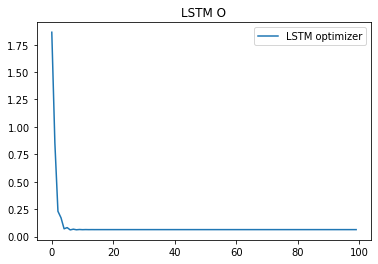

In [82]:
plt.plot(model.training_losses, label='LSTM optimizer')
plt.legend()
plt.title("LSTM O")

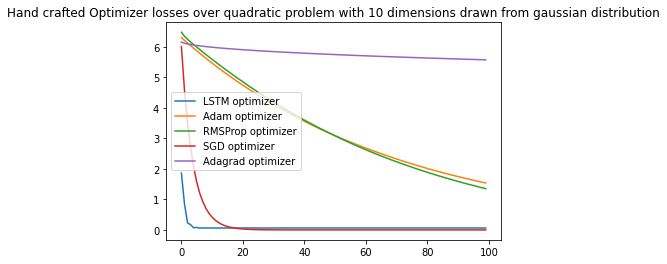

In [83]:
# plt.plot(model.training_losses)
plt.plot(model.training_losses, label='LSTM optimizer')
plt.plot(adam_history.history['loss'], label='Adam optimizer')
plt.plot(rms_prop_history.history['loss'], label='RMSProp optimizer')
plt.plot(sgd_history.history['loss'], label='SGD optimizer')
plt.plot(adagrad_history.history['loss'], label='Adagrad optimizer')

plt.title('Hand crafted Optimizer losses over quadratic problem with 10 dimensions drawn from gaussian distribution')
# show a legend on the plot
plt.legend()

### Validation losses

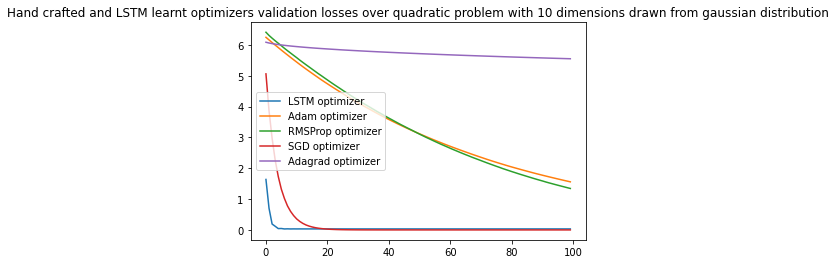

In [84]:
# plt.plot(model.training_losses)
plt.plot(model.validation_losses, label='LSTM optimizer')
plt.plot(adam_history.history['val_loss'], label='Adam optimizer')
plt.plot(rms_prop_history.history['val_loss'], label='RMSProp optimizer')
plt.plot(sgd_history.history['val_loss'], label='SGD optimizer')
plt.plot(adagrad_history.history['val_loss'], label='Adagrad optimizer')

plt.title('Hand crafted and LSTM learnt optimizers validation losses over quadratic problem with 10 dimensions drawn from gaussian distribution')
# show a legend on the plot
plt.legend()

### Accuracy metrics

In [85]:
adam_preds = adam_model(test_x)
rms_preds = rmsprop_model(test_x)
sgd_preds = sgd_model(test_x)
adagrad_preds = adagrad_model(test_x)
lstm_optimizer_preds = model(test_x, model.tensor_trainable_weights)

In [86]:
lstm_optimizer_preds = tf.reshape(lstm_optimizer_preds, test_y.shape)
adam_preds = tf.reshape(adam_preds, test_y.shape)
rms_preds = tf.reshape(rms_preds, test_y.shape)
adagrad_preds = tf.reshape(adagrad_preds, test_y.shape)
sgd_preds = sgd_model(test_x)

In [87]:
def print_accuracy_metrics(optimizer_name, test_y, preds):
    print(f"*****{optimizer_name} Accuracy metrics******")
    print("Mean absolute error =", round(sm.mean_absolute_error(test_y, preds), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(test_y, preds), 2)) 
    print("Median absolute error =", round(sm.median_absolute_error(test_y, preds), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(test_y, preds), 2)) 
    print("R2 score =", round(sm.r2_score(test_y, preds), 2))
    print()

In [88]:
def create_df_for_metrics(optimizer_name, test_y, preds):
    data = {
      "Mean Absolute Error": [round(sm.mean_absolute_error(test_y, preds), 2)],
      "Mean Squared Error": [round(sm.mean_squared_error(test_y, preds), 2)],
      "Median Absolut Error": [round(sm.median_absolute_error(test_y, preds), 2)],
      "Explain variance score": [round(sm.explained_variance_score(test_y, preds), 2)],
      "R2 score": [round(sm.r2_score(test_y, preds), 2)]
    }
    
    df = pd.DataFrame(data, index=[optimizer_name])
    return(df)

In [89]:
def display_accuracy_metrics():
    df_lstm = create_df_for_metrics("LSTM_optimizer", tf.squeeze(test_y), tf.squeeze(lstm_optimizer_preds))
    df_adagrad = create_df_for_metrics("Adagrad", tf.squeeze(test_y), tf.squeeze(adagrad_preds))
    df_rms = create_df_for_metrics("RMSProp", tf.squeeze(test_y), tf.squeeze(rms_preds))
    df_adam = create_df_for_metrics("ADAM", tf.squeeze(test_y), tf.squeeze(adam_preds))
    df_sgd = create_df_for_metrics("SGD", tf.squeeze(test_y), tf.squeeze(sgd_preds))
    df = df_lstm.append([df_adagrad, df_rms, df_adam, df_sgd])
    return df

In [90]:
display_accuracy_metrics()

,Mean Absolute Error,Mean Squared Error,Median Absolut Error,Explain variance score,R2 score
LSTM_optimizer,0.15,0.03,0.12,0.99,0.99
Adagrad,1.93,5.67,1.68,0.13,0.11
RMSProp,0.92,1.31,0.80,0.80,0.79
ADAM,0.99,1.51,0.85,0.77,0.76
SGD,0.00,0.00,0.00,1.00,1.00


In [91]:
print_accuracy_metrics("LSTM_optimizer", tf.squeeze(test_y), tf.squeeze(lstm_optimizer_preds))
print_accuracy_metrics("Adagrad", tf.squeeze(test_y), tf.squeeze(adagrad_preds))
print_accuracy_metrics("RMSProp", tf.squeeze(test_y), tf.squeeze(rms_preds))
print_accuracy_metrics("ADAM", tf.squeeze(test_y), tf.squeeze(adam_preds))
print_accuracy_metrics("SGD", tf.squeeze(test_y), tf.squeeze(sgd_preds))

*****LSTM_optimizer Accuracy metrics******
Mean absolute error = 0.15
Mean squared error = 0.03
Median absolute error = 0.12
Explain variance score = 0.99
R2 score = 0.99

*****Adagrad Accuracy metrics******
Mean absolute error = 1.93
Mean squared error = 5.67
Median absolute error = 1.68
Explain variance score = 0.13
R2 score = 0.11

*****RMSProp Accuracy metrics******
Mean absolute error = 0.92
Mean squared error = 1.31
Median absolute error = 0.8
Explain variance score = 0.8
R2 score = 0.79

*****ADAM Accuracy metrics******
Mean absolute error = 0.99
Mean squared error = 1.51
Median absolute error = 0.85
Explain variance score = 0.77
R2 score = 0.76

*****SGD Accuracy metrics******
Mean absolute error = 0.0
Mean squared error = 0.0
Median absolute error = 0.0
Explain variance score = 1.0
R2 score = 1.0

